## Dependencies

In [1]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.environ import ConstraintList
from pyomo.dae import *
from calculations.datahandling import*
from calculations.data_processor import* 
import itertools
import matplotlib.pyplot as plt

## Reading in parameters and topology data

In [2]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputParameter(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputParameter('data/Parameters.xlsx')


def InputTopology(data_file):
    inputdata = pd.read_excel(data_file,sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Pump_min','Pump_max', 'Q','LRL','HRL','RL_start', 'Spill_min', 'Spill_max']].dropna()
    return data 
topology = InputTopology('data/Ormset_Data.xlsx')

    #Volume-head relationship:
def InputHead(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column], inputdata[head_column]))
    return data_volhead
headvol_Ormset=InputHead('data/Ormset_Data.xlsx')

def InputHead2(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head2')
    volume_column='Mm3'
    head_column='m'
    data_volhead = dict(zip(inputdata[volume_column].dropna(), inputdata[head_column].dropna()))
    return data_volhead
headvol_Buaset=InputHead2('data/Ormset_Data.xlsx')

    #Flow-head relationship:
def InputFlow(data_file): 
    inputdata = pd.read_excel(data_file, sheet_name='flow')
    data_flowhead = {}
    data_flowhead['ormset_headflow'] = inputdata[['Moh','m3/s']].dropna()
    return data_flowhead
headflow=InputFlow('data/Ormset_Data.xlsx')

display(topology)
display(headvol_Ormset)
display(headflow)

def interpolate_head(volume, head_dict):
    volumes = list(head_dict.keys())
    heads = list(head_dict.values())
    return np.interp(volume, volumes, heads)

test=interpolate_head(45, headvol_Ormset)
print(test)


{'ormset': Ormsetfoss  Pmin  Pmax  Vmax  Vmin  Vstart  Qmin  Qmax  Pump_min  Pump_max  \
 Hydro1       0.0  41.0  45.0   0.0    45.0   0.0  12.0       0.0       0.0   
 Hydro2       0.0  30.0  20.0   0.0    20.0   0.0  12.0       0.0       1.6   
 
 Ormsetfoss    Q    LRL    HRL  RL_start  Spill_min   Spill_max  
 Hydro1      4.0  375.0  389.0     389.0        0.0  10000000.0  
 Hydro2      2.0  326.0  331.5     331.5        0.0  10000000.0  }

{0.0: 375.0,
 2.08333: 375.99242,
 4.16667: 376.83333,
 6.25: 377.63462,
 8.33333: 378.40476,
 10.41667: 379.09314,
 12.5: 379.70588,
 14.58333: 380.30093,
 16.66667: 380.87963,
 18.75: 381.45833,
 20.83333: 382.03509,
 22.91667: 382.58333,
 25.0: 383.13158,
 27.08333: 383.67982,
 29.16667: 384.22807,
 31.25: 384.77632,
 33.33333: 385.32456,
 35.41667: 385.85417,
 37.5: 386.35714,
 39.58333: 386.85317,
 41.66667: 387.33333,
 43.75: 387.79348,
 45.83333: 388.24638,
 47.91667: 388.65278,
 50.0: 389.0}

{'ormset_headflow':      Moh  m3/s
 0  388.0   0.0
 1  388.2   4.9
 2  388.5  20.4
 3  389.0  68.4}

388.0652204347847


In [3]:
start = '2018-09-01 00:00:00'
end = '2020-08-31 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

    #Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_load= read_csv_data('data/Normal_consumption.csv')
load_unscaled=convert_to_dict(input_data_load, start, end, 'H')
load_h=scale_dict(load_unscaled, 0.001)

hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour

rationing_price=max(market_prices_h.values())


print(rationing_price)

print(min(load_h.values()))


80.75
7.532307620167306


In [4]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('data/Data_inflow.csv', parse_dates=True, index_col=0)

# Extract Ormsetvatn and Buavatn columns
ormsetvatn = df['Ormsetvatn']
buavatn = df['Buavatn']

# Calculate overall yearly average
overall_yearly_average_ormsetvatn1 = ormsetvatn.groupby(ormsetvatn.index.year).sum().sum() / len(ormsetvatn.index.year.unique())
overall_yearly_average_buavatn1 = buavatn.groupby(buavatn.index.year).sum().sum() / len(buavatn.index.year.unique())

# Print the results
print("Alex data  - Overall Yearly Average for Ormsetvatn:", overall_yearly_average_ormsetvatn1)
print("Alex data - Overall Yearly Average for Buavatn:", overall_yearly_average_buavatn1)

# Read the CSV file into a DataFrame
df = pd.read_csv('100year_data_PVGIS.csv', parse_dates=True, index_col=0)

# Extract Ormsetvatn and Buavatn columns
ormsetvatn = df['Ormsetvatn']
buavatn = df['Buavatn']

# Calculate overall yearly average
overall_yearly_average_ormsetvatn2 = ormsetvatn.groupby(ormsetvatn.index.year).sum().sum() / len(ormsetvatn.index.year.unique())
overall_yearly_average_buavatn2 = buavatn.groupby(buavatn.index.year).sum().sum() / len(buavatn.index.year.unique())

# Print the results
print("100year data -  Overall Yearly Average for Ormsetvatn:", overall_yearly_average_ormsetvatn2)
print("100year data - Overall Yearly Average for Buavatn:", overall_yearly_average_buavatn2)


print("Scaling factor for Ormsetvatn: ", overall_yearly_average_ormsetvatn1/overall_yearly_average_ormsetvatn2)
print("Scaling factor for Buasetvatn: ", overall_yearly_average_buavatn1/overall_yearly_average_buavatn2)

Alex data  - Overall Yearly Average for Ormsetvatn: 39014.284
Alex data - Overall Yearly Average for Buavatn: 3698.7699999999995
100year data -  Overall Yearly Average for Ormsetvatn: 38432.08979634828
100year data - Overall Yearly Average for Buavatn: 3643.4678123692556
Scaling factor for Ormsetvatn:  1.015148648089052
Scaling factor for Buasetvatn:  1.0151784482472983


## Functions


In [5]:


# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'Ri': rationing_price, 'Si': 300, 
             'inflow_scenarios' : ['High', 'Avg', 'Low'], 
             'inflow_probabilities' : {'High': 1/3, 'Avg': 1/3, 'Low': 1/3} }




# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])

def pump_bounds(model, i, j):
    return(model.Pump_min[i], model.Pump_max[i])

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])

def init_v(model, i, j):
    return model.v0[i]

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])

def spill_bounds(model, i, j):
    return (model.S_min[i], model.S_max[i])

#initializing scenarios for inflow


# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j]  == model.L[j] - (model.r[j])
def power_rule(model,i, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return  10**-6*model.eff * model.rho * model.g * model.HRL[i] * model.q[i, j] == model.p[i, j]#MW

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, min( model.periods)] >= model.v0[i] - tolerance

def market_cons(model, j):
    return model.m['Buy',j] <= 10



# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])


#def v_init_rule(model, i, v):
   #return model.v_init[i,v]==model.v0[i]*v/100


    
def volume_change_rule(model, i, j): 
    if j==1:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow1[j]*fm3) + (model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v0[i]) - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) - (model.pump[i,j]*fm3) - (model.s[i,j]*fm3)
    elif j == min(model.periods): 
        if i == 'Hydro1':
            return model.v[i, j] == (model.v_init1) - (model.q[i, j] *fm3) + (model.inflow1[j]*fm3) + (model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i == 'Hydro2':
        # Include the discharge from Hydro1 as inflow to Hydro2 
            return model.v[i, j] == (model.v_init2) - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) - (model.pump[i,j]*fm3) - (model.s[i,j]*fm3)
    else:
        if i =='Hydro1': 
            return model.v[i, j ] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow1[j]*fm3) +(model.pump['Hydro2',j]*fm3) -(model.s[i,j]*fm3)
        elif i =='Hydro2':
            return model.v[i, j] == model.v[i,j-1] - (model.q[i, j] *fm3) + (model.inflow2[j]*fm3) - (model.pump[i,j]*fm3) -(model.s[i,j]*fm3)   
    
        
    
         
    
def OBJ_one_stage(model):
    return model.Ri*sum(model.r[j] for j in model.periods) + model.alpha


def OBJ_last_stage(model):
    return model.Ri*sum(model.r[j] for j in model.periods) 




## Solve last stage setup


In [6]:
def solve_last_stage(constants, topology, stage, states, inflow_scenario1, inflow_scenario2):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities


    # Sets to model hydro topology
    model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])
    model.inflow1=pyo.Param(model.periods, initialize={j: inflow_scenario1[j] for j in model.periods})
    model.inflow2=pyo.Param(model.periods, initialize={j: inflow_scenario2[j] for j in model.periods})
    
    # --- Variables ----
    model.inflow = pyo.Var(model.plants,  model.periods,   within=NonNegativeReals)
    model.p = pyo.Var(model.plants,  model.periods,    bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods,  within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods,   bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods,   within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods,  bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods,  within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods,  bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.solar_curt=pyo.Var(model.periods, within=NonNegativeReals)
    #--- CONSTRAINTS---

    model.market_cons=pyo.Constraint(model.periods, rule=market_cons)
    model.load_cons = pyo.Constraint( model.periods,   rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods,  rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    
    # --- Objective function---
    model.obj=pyo.Objective(rule=OBJ_last_stage, sense=pyo.minimize)
    
        
    return model
    


def solve(model):
    #solver 
    opt = SolverFactory('gurobi', solver_io="python") 
    #opt.options['NonConvex']=2    #defining dual 
    model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
    results = opt.solve(model,tee=False) 
            
    return results, model

def displayresults(model):
    return print(model.dual.display())




In [7]:

Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

scenarios1=[]
scenarios2=[]

res_dict = {}
res_dict2 = {}

res_dict_double = {}
res_dict2_double = {}


start_year = 1960
end_year = 1990

for i in range(start_year, end_year, 1):
    res1, res2, sol = csv_to_dataframe('100year_data_PVGIS.csv', f'{i}-09-01', f'{i+1}-08-31')

    res_dict[i] = {i + 1: value for i, value in enumerate(res1)}
    res_dict2[i] = {i + 1: value for i, value in enumerate(res2)}
    

    start_dup = len(res_dict[i])

    res_dict_double[i] = {i  + start_dup + 1: value for i, value in enumerate(res1)}
    res_dict2_double[i] = {i + start_dup + 1: value for i, value in enumerate(res2)}
    
    ormset_double = Merge(res_dict[i], res_dict_double[i])
    buavatn_double = Merge(res_dict2[i], res_dict2_double[i])

    scenarios1.append(ormset_double)
    scenarios2.append(buavatn_double)
    
        

expected={}
Dual_values1={}
Dual_values2={}
for state in state_combinations: 
        expected_scenario=0
        Dual1=0
        Dual2=0
        for i in range(len(scenarios1)):
                m=solve_last_stage(constants, topology, 104, state, scenarios1[i], scenarios2[i])
                solve(m)
                expected_scenario+=m.obj()
                Dual1+=m.dual.get(m.volume_change_cons['Hydro1',max(m.periods)])
                Dual2+=m.dual.get(m.volume_change_cons['Hydro2',max(m.periods)])            
        expected[104, state]=expected_scenario/len(scenarios1)
        Dual_values1[104, state]=Dual1/len(scenarios1)
        Dual_values2[104, state]=Dual2/len(scenarios1)
        


In [8]:
print(expected)
print(Dual_values1)
print(Dual_values2)
len(scenarios1)

{(104, (0, 0)): 45649.39004902342, (104, (0, 4)): 0.0, (104, (0, 8)): 0.0, (104, (0, 12)): 0.0, (104, (0, 16)): 0.0, (104, (0, 20)): 0.0, (104, (9, 0)): 0.0, (104, (9, 4)): 0.0, (104, (9, 8)): 0.0, (104, (9, 12)): 0.0, (104, (9, 16)): 0.0, (104, (9, 20)): 0.0, (104, (18, 0)): 0.0, (104, (18, 4)): 0.0, (104, (18, 8)): 0.0, (104, (18, 12)): 0.0, (104, (18, 16)): 0.0, (104, (18, 20)): 0.0, (104, (27, 0)): 0.0, (104, (27, 4)): 0.0, (104, (27, 8)): 0.0, (104, (27, 12)): 0.0, (104, (27, 16)): 0.0, (104, (27, 20)): 0.0, (104, (36, 0)): 0.0, (104, (36, 4)): 0.0, (104, (36, 8)): 0.0, (104, (36, 12)): 0.0, (104, (36, 16)): 0.0, (104, (36, 20)): 0.0, (104, (45, 0)): 0.0, (104, (45, 4)): 0.0, (104, (45, 8)): 0.0, (104, (45, 12)): 0.0, (104, (45, 16)): 0.0, (104, (45, 20)): 0.0}
{(104, (0, 0)): -31157.314825000005, (104, (0, 4)): 0.0, (104, (0, 8)): 0.0, (104, (0, 12)): 0.0, (104, (0, 16)): 0.0, (104, (0, 20)): 0.0, (104, (9, 0)): 0.0, (104, (9, 4)): 0.0, (104, (9, 8)): 0.0, (104, (9, 12)): 0.0, (1

30

In [9]:
def solve_one_stage(constants, topology, stage, states, inflow_scenario1, inflow_scenario2, alpha_values, dual_res1, dual_res2):
    # Create a ConcreteModel
    model = pyo.ConcreteModel(name="SDP")

    # Define the inflow scenarios and associated probabilities
    model.scenarios=pyo.Set(initialize=constants['inflow_scenarios'])
    
    
    
    # Sets to model hydro topology
    if stage>1:
        model.periods = pyo.Set(initialize= range ((stage-1)*7*24, (stage)*7*24 + 1, 1))
    else:
        model.periods = pyo.Set(initialize= range ((stage-1)*7*24 + 1, (stage)*7*24 + 1, 1))
                      #these sets must be defined in the latex report as well
    model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
    model.market = pyo.Set(initialize=['Buy','Sell'])


    # Hydro parameters
    model.eff = pyo.Param(initialize=constants['eff'])
    model.rho = pyo.Param(initialize=constants['rho'])
    model.g = pyo.Param(initialize=constants['g'])

    
    # Cost parameters
    model.Mi = pyo.Param(model.periods, initialize={j: market_prices_h[j] for j in model.periods})            #Market price varying
    model.Ri=pyo.Param(initialize=constants['Ri'])  #Rationing cost for plants
    model.Si=pyo.Param(model.plants, initialize=constants['Si'])  #Spillage  costs for plants 

    #Plant parameters
    model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
    model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

    #Load parameters
    model.L = pyo.Param(model.periods, initialize={j: load_h[j] for j in model.periods})

    #Topology parameters
    model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
    model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
    model.Pump_min=pyo.Param(model.plants, initialize=topology['ormset']['Pump_min'])
    model.Pump_max=pyo.Param(model.plants, initialize=topology['ormset']['Pump_max'])
    model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
    model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
    model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
    model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
    model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
    model.S_min=pyo.Param(model.plants, initialize=topology['ormset']['Spill_min'])
    model.S_max=pyo.Param(model.plants, initialize=topology['ormset']['Spill_max'])
    model.v_init1=pyo.Param(initialize=states[0])
    model.v_init2=pyo.Param(initialize= states[1])
    model.inflow1=pyo.Param(model.periods, initialize={j: inflow_scenario1[j] for j in model.periods})
    model.inflow2=pyo.Param(model.periods, initialize={j: inflow_scenario2[j] for j in model.periods})
    #Scenario parameter
    
    # --- Variables ----
    model.p = pyo.Var(model.plants,  model.periods,    bounds=p_bounds)                   #Power production
    model.m = pyo.Var(model.market,  model.periods,  within=NonNegativeReals)       #Power bougth from lack of production
    model.q = pyo.Var(model.plants,  model.periods,   bounds=q_bounds)
    model.q_out=pyo.Var(model.plants,  model.periods,   within=NonNegativeReals)
    model.pump=pyo.Var(model.plants,  model.periods,  bounds=pump_bounds)     #Time dependent pump discharge between lower and upper reservoir (dependent on reservoir balance)
    model.v = pyo.Var(model.plants,  model.periods,  bounds=vol_bounds) #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)
    model.r=pyo.Var( model.periods,  within=NonNegativeReals) #amount rationed 
    model.s=pyo.Var(model.plants,  model.periods,  bounds=spill_bounds) #amount spilled for each reservoir (should have bounds)
    model.solar_curt=pyo.Var(model.periods, within=NonNegativeReals)
    #Creating future cost variable
    model.alpha=pyo.Var()
 
    #--- CONSTRAINTS---
    model.load_cons = pyo.Constraint( model.periods,   rule=load_rule)
    model.power_prod = pyo.Constraint(model.plants,  model.periods,  rule=power_rule) 
    model.volume_change_cons = pyo.Constraint(model.plants,  model.periods,  rule=volume_change_rule)
    model.market_cons=pyo.Constraint(model.periods, rule=market_cons)
    # Creating a constraint list for the FCF
    model.alpha_cons=pyo.ConstraintList()
    
    # List to store expected cost from previous stage
    phi_values = []
    
    #List to store dual value of reservoir 1 & 2 in previous stage
    lambda1_values = []
    lambda2_values = []

    #List to store initial volumes introduced in states
    state_volumes=[]
    
    #Appending values for previous stage 
    for key in alpha_values:
        if key[0]==stage+1:
            state_volumes.append(key[1])
            phi_values.append(alpha_values[key])
            lambda1_values.append(dual_res1[key])
            lambda2_values.append(dual_res2[key])
        else:
            pass
    
    # Calculate the FCF for each discrete point and constrain alpha through cuts: a>= phi + lambda1*(x1-x1_hat) + lambda2*(x2-x2_hat) for each state, where x1 is the average end-of-stage volume for all scenarios
    for i in range(len(state_volumes)):
        model.alpha_cons.add(model.alpha >= phi_values[i] + lambda1_values[i]*(model.v['Hydro1', max(model.periods)] -  (state_volumes[i][0])) + lambda2_values[i]*(model.v['Hydro2', max(model.periods)]  - (state_volumes[i][1])))
        
    # --- Objective function---
    
    
    model.obj=pyo.Objective(rule=OBJ_one_stage, sense=pyo.minimize)
    
        
    return model
    

In [10]:
stages=reversed(range(1, 103 + 1, 1))
Hydro1_initial=[i for i in range (0, 45+9, 9)]
Hydro2_initial=[i for i in range (0, 20+4, 4)]   
state_combinations =[p for p in itertools.product(Hydro1_initial, Hydro2_initial)]

scenarios1=[]
scenarios2=[]

res_dict = {}
res_dict2 = {}

res_dict_double = {}
res_dict2_double = {}


start_year = 1960
end_year = 1990

for i in range(start_year, end_year, 1):
    res1, res2, sol = csv_to_dataframe('100year_data_PVGIS.csv', f'{i}-09-01', f'{i+1}-08-31')

    res_dict[i] = {i + 1: value for i, value in enumerate(res1)}
    res_dict2[i] = {i + 1: value for i, value in enumerate(res2)}
    

    start_dup = len(res_dict[i])

    res_dict_double[i] = {i  + start_dup + 1: value for i, value in enumerate(res1)}
    res_dict2_double[i] = {i + start_dup + 1: value for i, value in enumerate(res2)}
    
    ormset_double = Merge(res_dict[i], res_dict_double[i])
    buavatn_double = Merge(res_dict2[i], res_dict2_double[i])

    scenarios1.append(ormset_double)
    scenarios2.append(buavatn_double)
    

alpha_dict={}
WV1_dict={}
WV2_dict={}
for stage in stages:
    for state in state_combinations: 
            expected_scenario=0
            Dual1=0
            Dual2=0
            alpha=0
            
            for i in range(len(scenarios1)):
                    m2=solve_one_stage(constants, topology, stage, state, scenarios1[i], scenarios2[i], expected, Dual_values1, Dual_values2)
                    solve(m2)
                    expected_scenario+=m2.obj()
                    Dual1+=m2.dual.get(m2.volume_change_cons['Hydro1',max(m2.periods)])
                    Dual2+=m2.dual.get(m2.volume_change_cons['Hydro2',max(m2.periods)]) 
                    alpha+=m2.alpha.value  
                    #print((m2.v['Hydro1', max(m2.periods)].value))
                    #print((m2.v['Hydro2', max(m2.periods)].value))
                    #print(state)
            expected[stage, state]=expected_scenario/len(scenarios1)
            Dual_values1[stage, state]=Dual1/len(scenarios1)
            
            Dual_values2[stage, state]=Dual2/len(scenarios1)
            alpha_dict[stage,state]=alpha/len(scenarios1)
            
                        
                        

C:\Users\oscar\AppData\Local\Temp\ipykernel_25812\2634132280.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("viridis")


<Figure size 2000x1500 with 0 Axes>

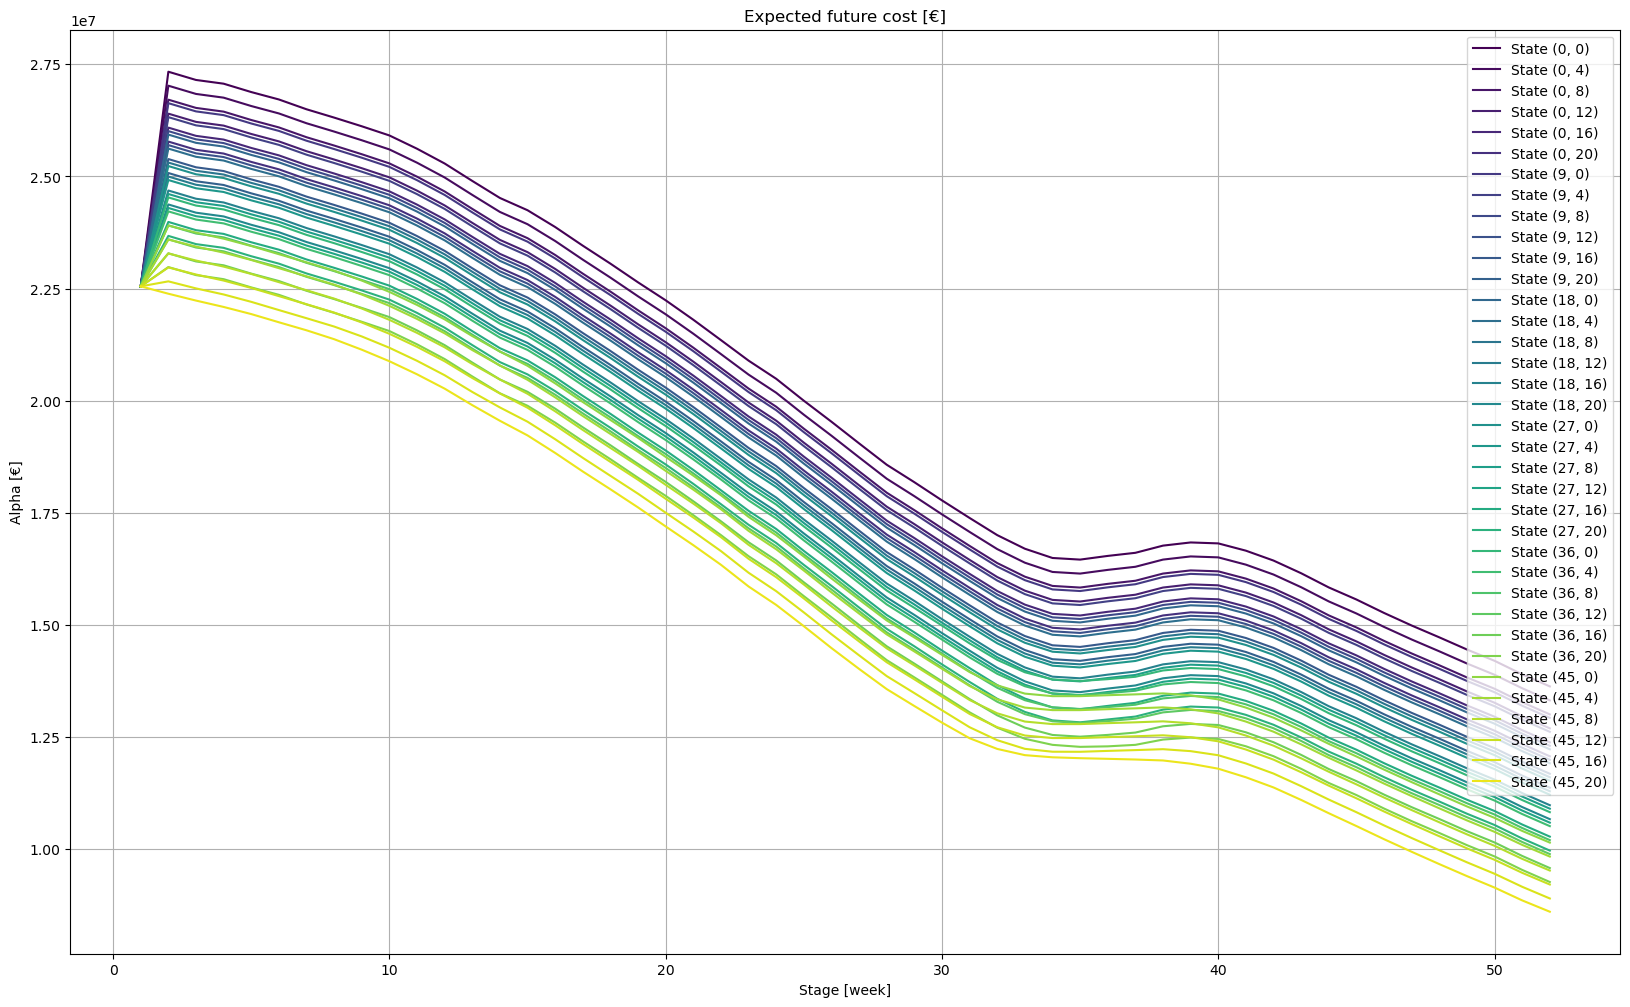

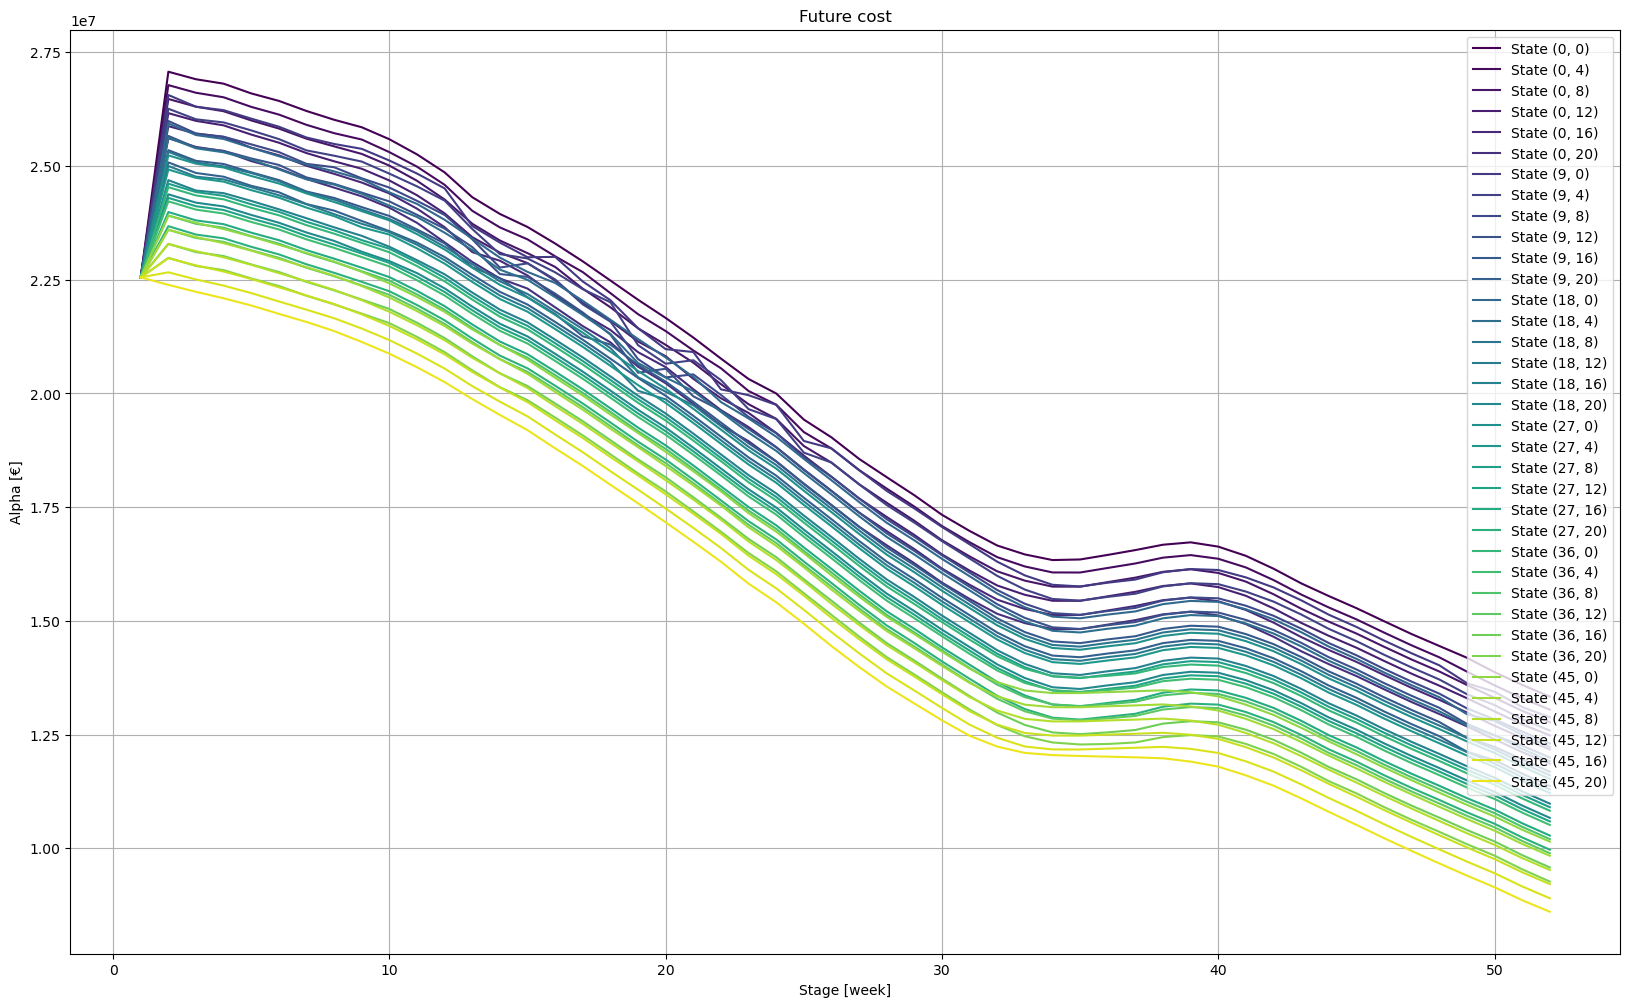

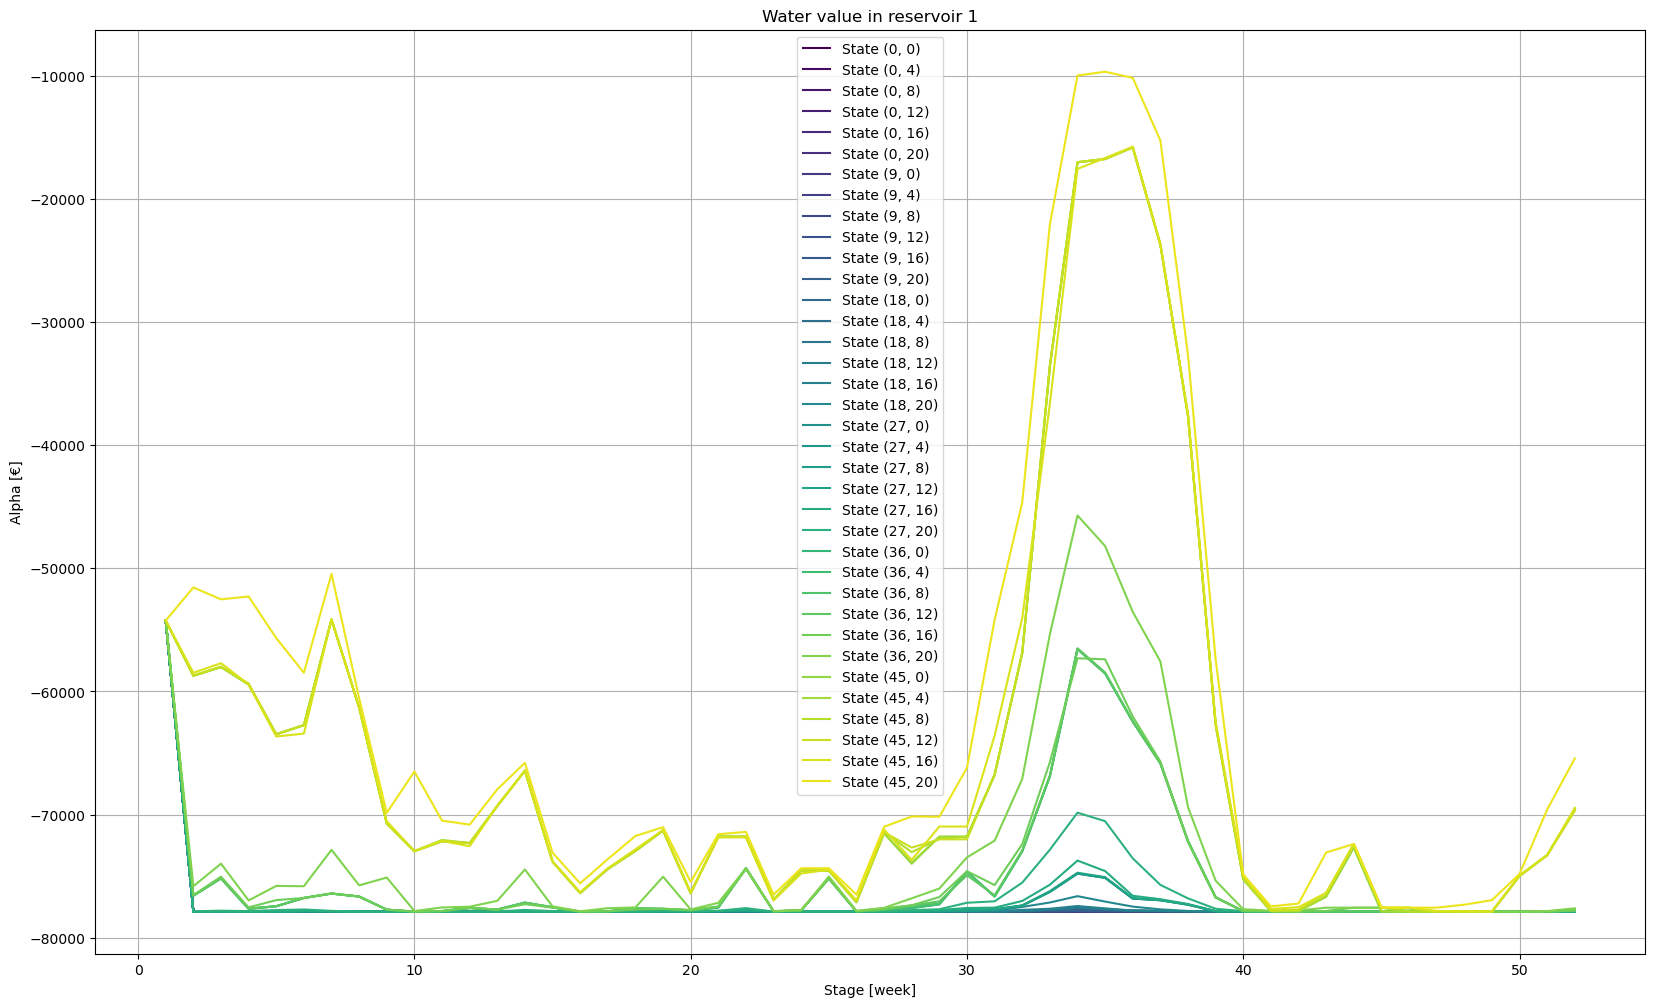

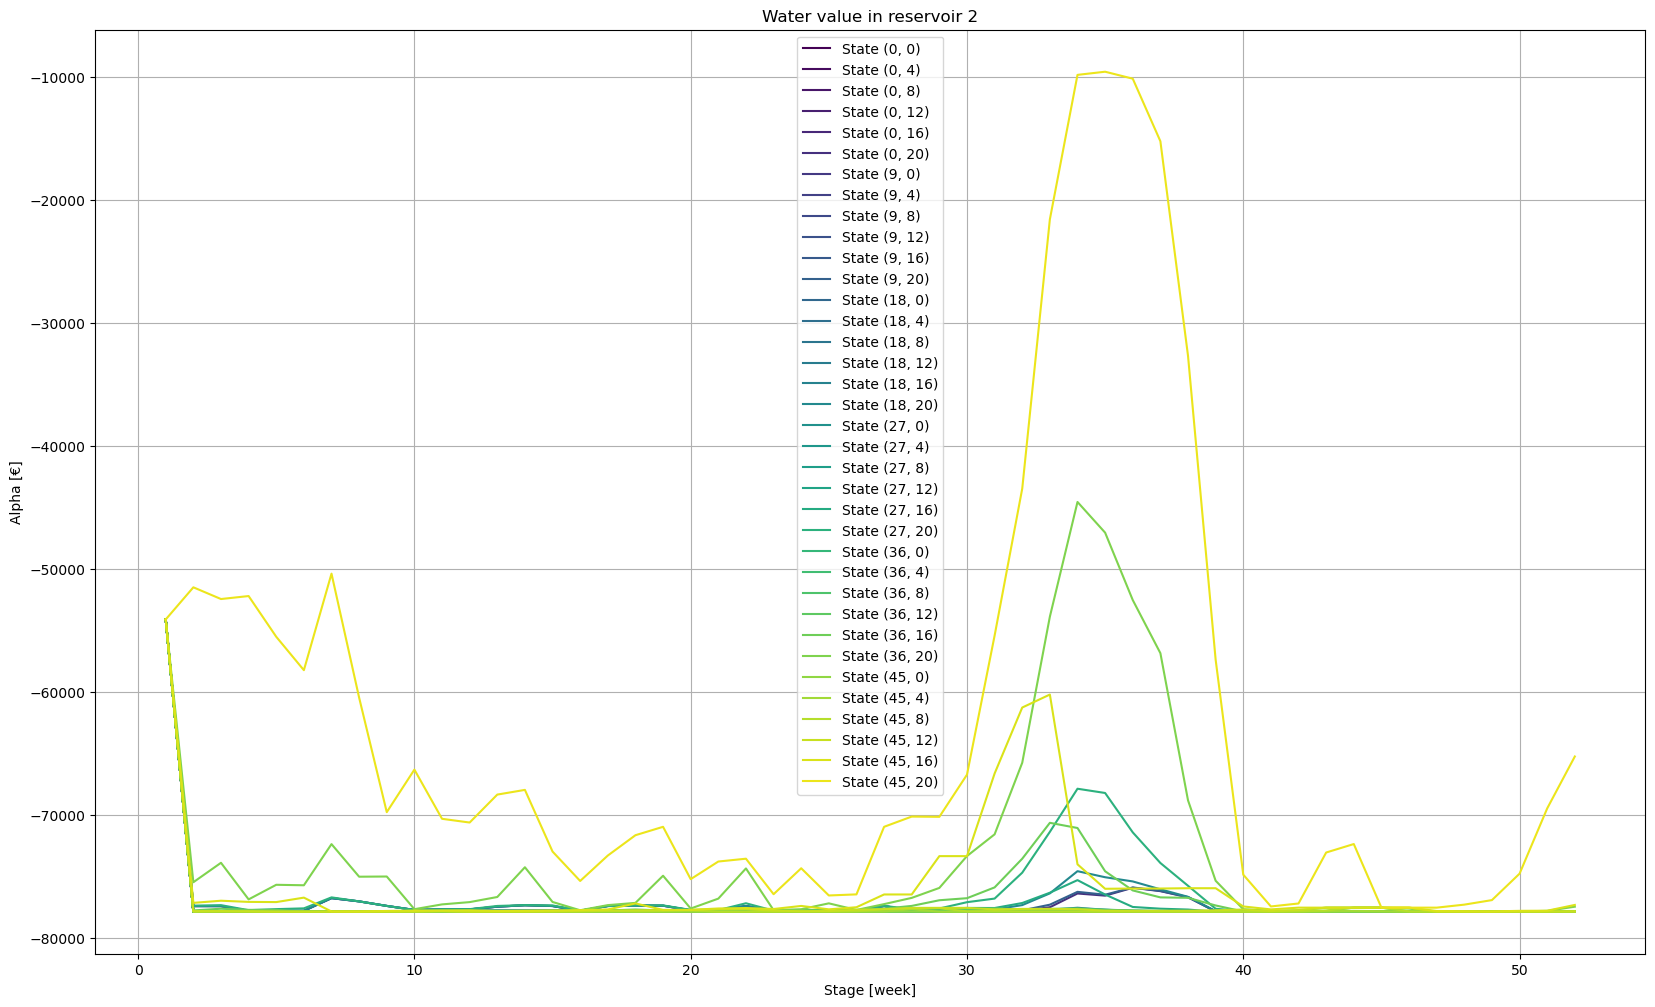

{(104, (0, 0)): 232779.22332070375, (104, (0, 4)): 25595.044565608758, (104, (0, 8)): 0.0, (104, (0, 12)): 0.0, (104, (0, 16)): 0.0, (104, (0, 20)): 0.0, (104, (9, 0)): 0.0, (104, (9, 4)): 0.0, (104, (9, 8)): 0.0, (104, (9, 12)): 0.0, (104, (9, 16)): 0.0, (104, (9, 20)): 0.0, (104, (18, 0)): 0.0, (104, (18, 4)): 0.0, (104, (18, 8)): 0.0, (104, (18, 12)): 0.0, (104, (18, 16)): 0.0, (104, (18, 20)): 0.0, (104, (27, 0)): 0.0, (104, (27, 4)): 0.0, (104, (27, 8)): 0.0, (104, (27, 12)): 0.0, (104, (27, 16)): 0.0, (104, (27, 20)): 0.0, (104, (36, 0)): 0.0, (104, (36, 4)): 0.0, (104, (36, 8)): 0.0, (104, (36, 12)): 0.0, (104, (36, 16)): 0.0, (104, (36, 20)): 0.0, (104, (45, 0)): 0.0, (104, (45, 4)): 0.0, (104, (45, 8)): 0.0, (104, (45, 12)): 0.0, (104, (45, 16)): 0.0, (104, (45, 20)): 0.0, (103, (0, 0)): 490206.26020313415, (103, (0, 4)): 222432.1069319801, (103, (0, 8)): 36361.03456257741, (103, (0, 12)): 0.0, (103, (0, 16)): 0.0, (103, (0, 20)): 0.0, (103, (9, 0)): 0.0, (103, (9, 4)): 0.0, (

In [ ]:
from itertools import cycle
from matplotlib.cm import get_cmap

# Define your dictionaries and titles
dictionaries = [expected, alpha_dict, Dual_values1, Dual_values2]
titles = ["Expected future cost [€]", "Future cost", "Water value in reservoir 1", "Water value in reservoir 2"]

# Set a larger figure size
plt.figure(figsize=(20, 15))

# Define a cycle of colormaps for states
cmap = get_cmap("viridis")

# Iterate through the dictionaries
for dictionary, title in zip(dictionaries, titles):
    states = {}

    # Create a separate figure for each dictionary
    plt.figure(figsize=(20, 12))

    for key, value in dictionary.items():
        stage, state = key
        if stage <= 52:  # Filter stages 0-52
            if state not in states:
                states[state] = {"stages": [], "values": []}
            states[state]["stages"].append(stage)
            states[state]["values"].append(value)

    # Plot each state with a different color
    for i, (state, data) in enumerate(states.items()):
        color = cmap(i/len(states))
        plt.plot(data["stages"], data["values"], label=f"State {state}", color=color)

    # Add labels, title, and legend for the current dictionary
    plt.xlabel("Stage [week]")
    plt.ylabel("Alpha [€]")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

print(expected)
print(Dual_values1)
print(Dual_values2)

In [ ]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(Dual_values1.values(), index=pd.MultiIndex.from_tuples(Dual_values1.keys(), names=['Stage', 'State']), columns=['Future Cost'])

# Pivot the DataFrame to have stages as columns and states as rows
pivot_df = df.pivot_table(index='State', columns='Stage', values='Future Cost', fill_value='')

# Specify the filename for the CSV file
csv_file = 'WV1_base_0.001.csv'

# Save the DataFrame to a CSV file
pivot_df.to_csv(csv_file)

In [ ]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(Dual_values2.values(), index=pd.MultiIndex.from_tuples(Dual_values2.keys(), names=['Stage', 'State']), columns=['Future Cost'])

# Pivot the DataFrame to have stages as columns and states as rows
pivot_df = df.pivot_table(index='State', columns='Stage', values='Future Cost', fill_value='')

# Specify the filename for the CSV file
csv_file = 'WV2_base_0.001.csv'

# Save the DataFrame to a CSV file
pivot_df.to_csv(csv_file)

In [ ]:
# Create a DataFrame from the dictionary
df = pd.DataFrame(expected.values(), index=pd.MultiIndex.from_tuples(expected.keys(), names=['Stage', 'State']), columns=['Future Cost'])

# Pivot the DataFrame to have stages as columns and states as rows
pivot_df = df.pivot_table(index='State', columns='Stage', values='Future Cost', fill_value='')

# Specify the filename for the CSV file
csv_file = 'PHI_base_0.001.csv'

# Save the DataFrame to a CSV file
pivot_df.to_csv(csv_file)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


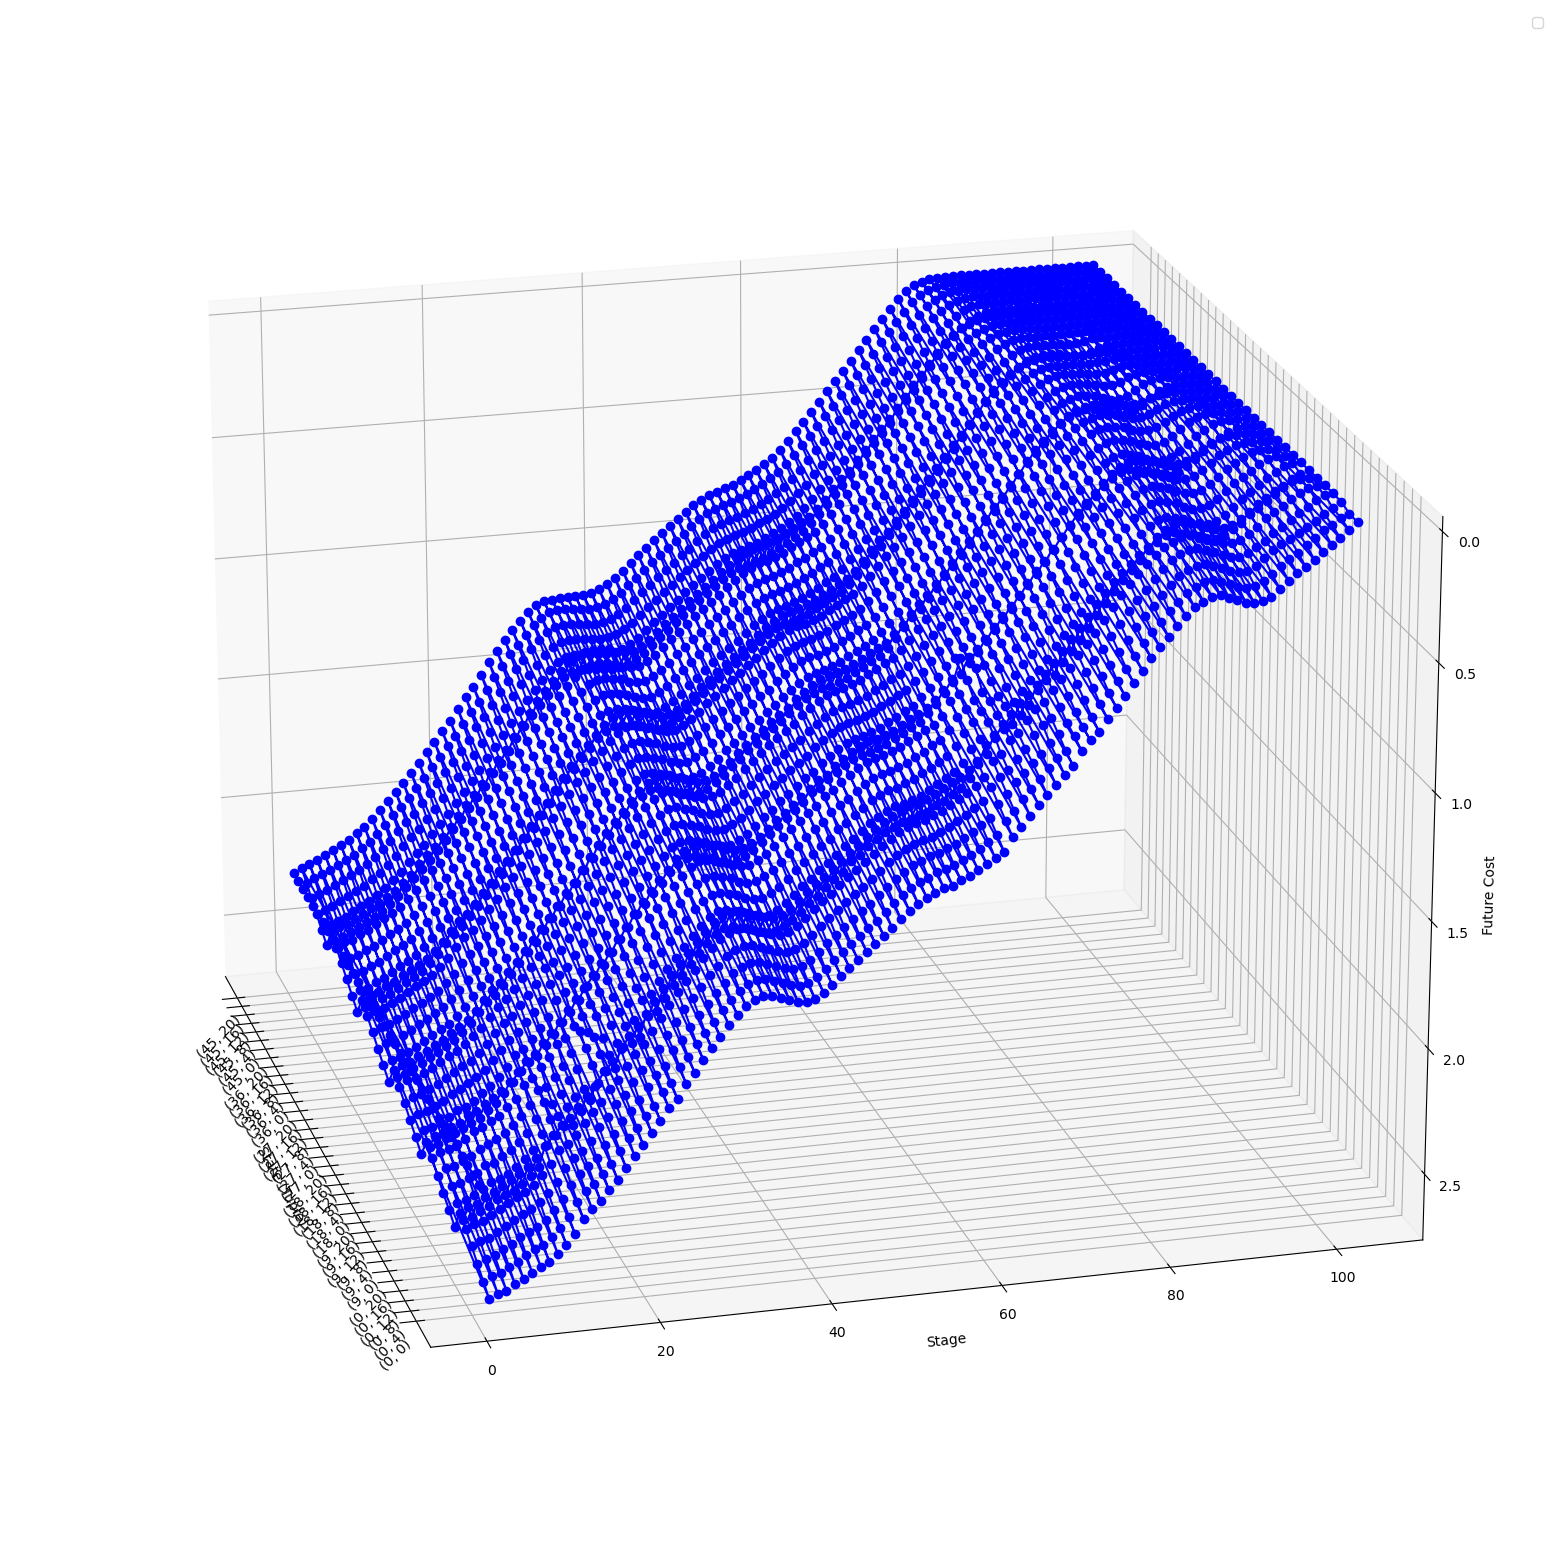

In [ ]:
# Extract the stage, state, and future cost values from the alpha_dict
stages = [stage for stage, state in alpha_dict.keys()]
state_tuples = [str(state) for stage, state in alpha_dict.keys()]
future_costs = list(alpha_dict.values())

# Create a 3D plot
fig = plt.figure(figsize=(40,20))
ax = fig.add_subplot(111, projection='3d')

# Map the state tuples to unique numeric values
state_mapping = {state: i for i, state in enumerate(state_tuples)}
state_numeric = [state_mapping[state] for state in state_tuples]

# Plot the data points with stage on the y-axis and state on the x-axis
ax.plot(state_numeric, stages, future_costs, c='b', marker='o')
ax.view_init(-160, 15) 
# Set labels for the axes
ax.set_xticks(list(state_mapping.values()))
ax.set_xticklabels(list(state_mapping.keys()), rotation=45)
ax.set_xlabel('State (Tuple)')
ax.set_ylabel('Stage')
ax.set_zlabel('Future Cost')
plt.legend()

plt.show()

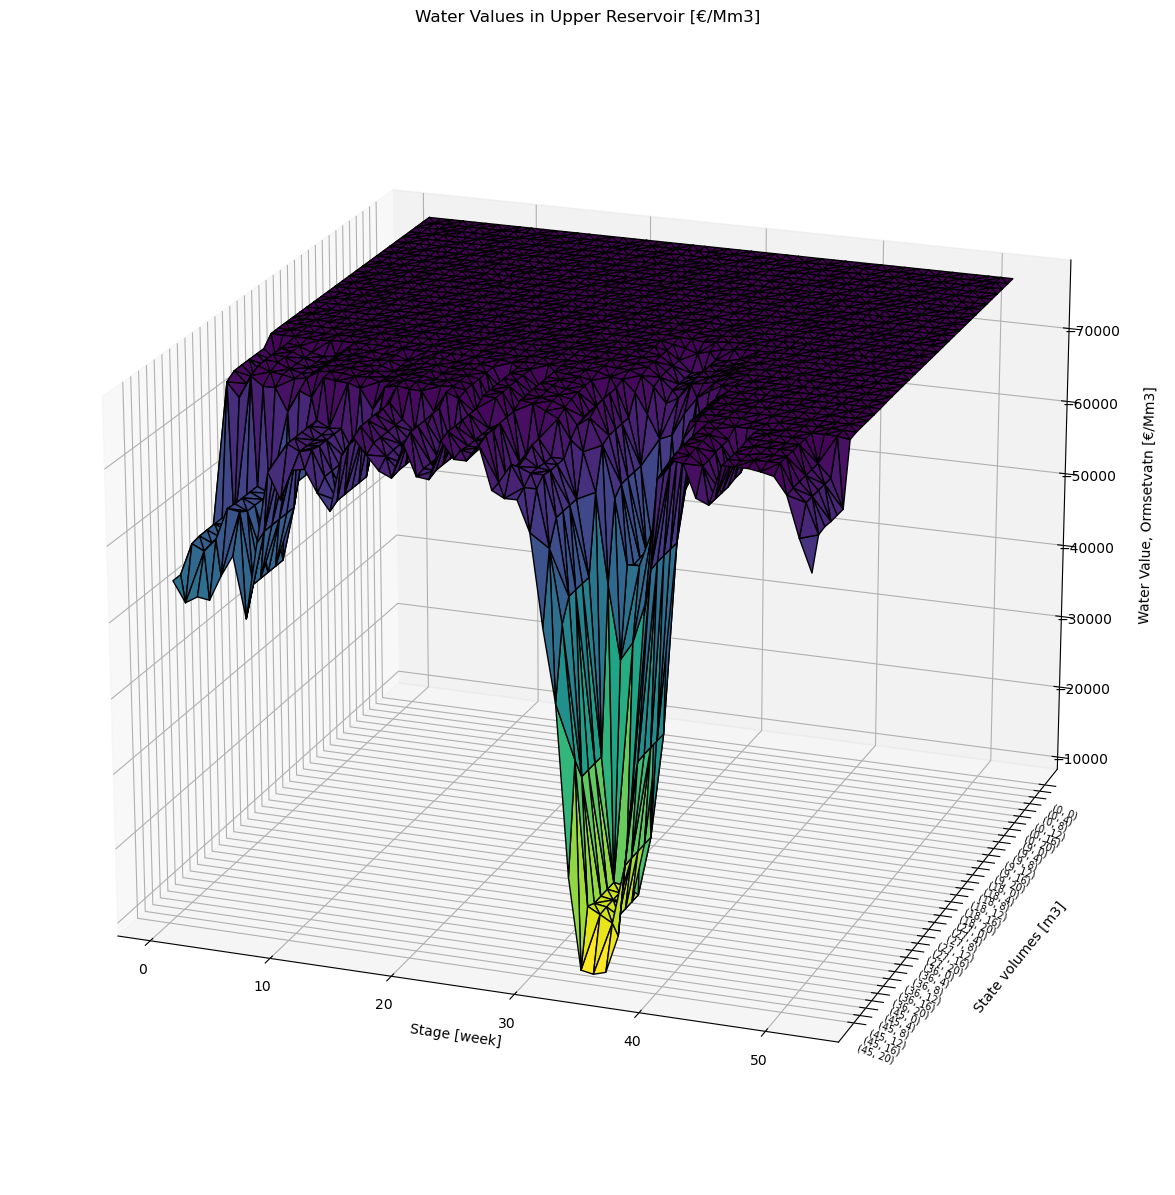

In [ ]:
from mpl_toolkits.mplot3d import Axes3D


# Extract the stage, state, and future cost values from the alpha_dict
stages = [stage for stage, state in Dual_values1.keys()]
state_tuples = [str(state) for stage, state in Dual_values1.keys()]
future_costs = list(Dual_values1.values())

# Map the state tuples to unique numeric values
state_mapping = {state: i for i, state in enumerate(state_tuples)}
state_numeric = [state_mapping[state] for state in state_tuples]


# Filter data for stages 0 to 52
filtered_stages = [stage for stage in stages if stage <= 52]
filtered_indices = [i for i, stage in enumerate(stages) if stage <= 52]

filtered_state_numeric = np.array(state_numeric)[filtered_indices]
filtered_future_costs = np.array(future_costs)[filtered_indices]

# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Create arrays for stages, state_numeric, and future_costs
stages_array = np.array(stages)
state_numeric_array = np.array(state_numeric)
future_costs_array = np.array(future_costs)

# Plot the 3D surface using plot_trisurf
ax.plot_trisurf(np.array(filtered_stages), filtered_state_numeric, filtered_future_costs, cmap='viridis', edgecolor='k')
ax.view_init(560, -110)
# Set labels for the axes with rotated and fewer tick labels, and adjust position
y_ticks = list(state_mapping.values())
y_labels = list(state_mapping.keys())
# Adjust the number of displayed ticks for better readability
stride = max(1, len(y_labels) // 36)  # Adjust the denominator for desired spacing
ax.set_yticks(y_ticks[::stride])
ax.set_yticklabels(y_labels[::stride], rotation=-20, ha='center', fontsize=7)   # Adjust rotation and ha as needed
ax.set_xlabel('Stage [week]')
ax.set_ylabel('State volumes [m3]', labelpad=20)
ax.set_zlabel('Water Value, Ormsetvatn [€/Mm3]', labelpad=20)

ax.tick_params(axis='y', pad=5)

# Adjust the position and spacing of y-axis ticks
#ax.yaxis.set_ticks_position('left')  # Set the ticks to the left side
#ax.yaxis.set_label_coords(-0.15, 0.5)  # Adjust the position as needed
#ax.yaxis.set_tick_params(pad=20)

plt.title("Water Values in Upper Reservoir [€/Mm3]")

# Add colorbar
#cbar = fig.colorbar(ax.plot_trisurf(stages_array, state_numeric_array, future_costs_array, cmap='viridis', edgecolor='k'), ax=ax, shrink=0.5, aspect=10)
#cbar.set_label('Water Value Reservoir 1 [€/Mm3]')

plt.show()

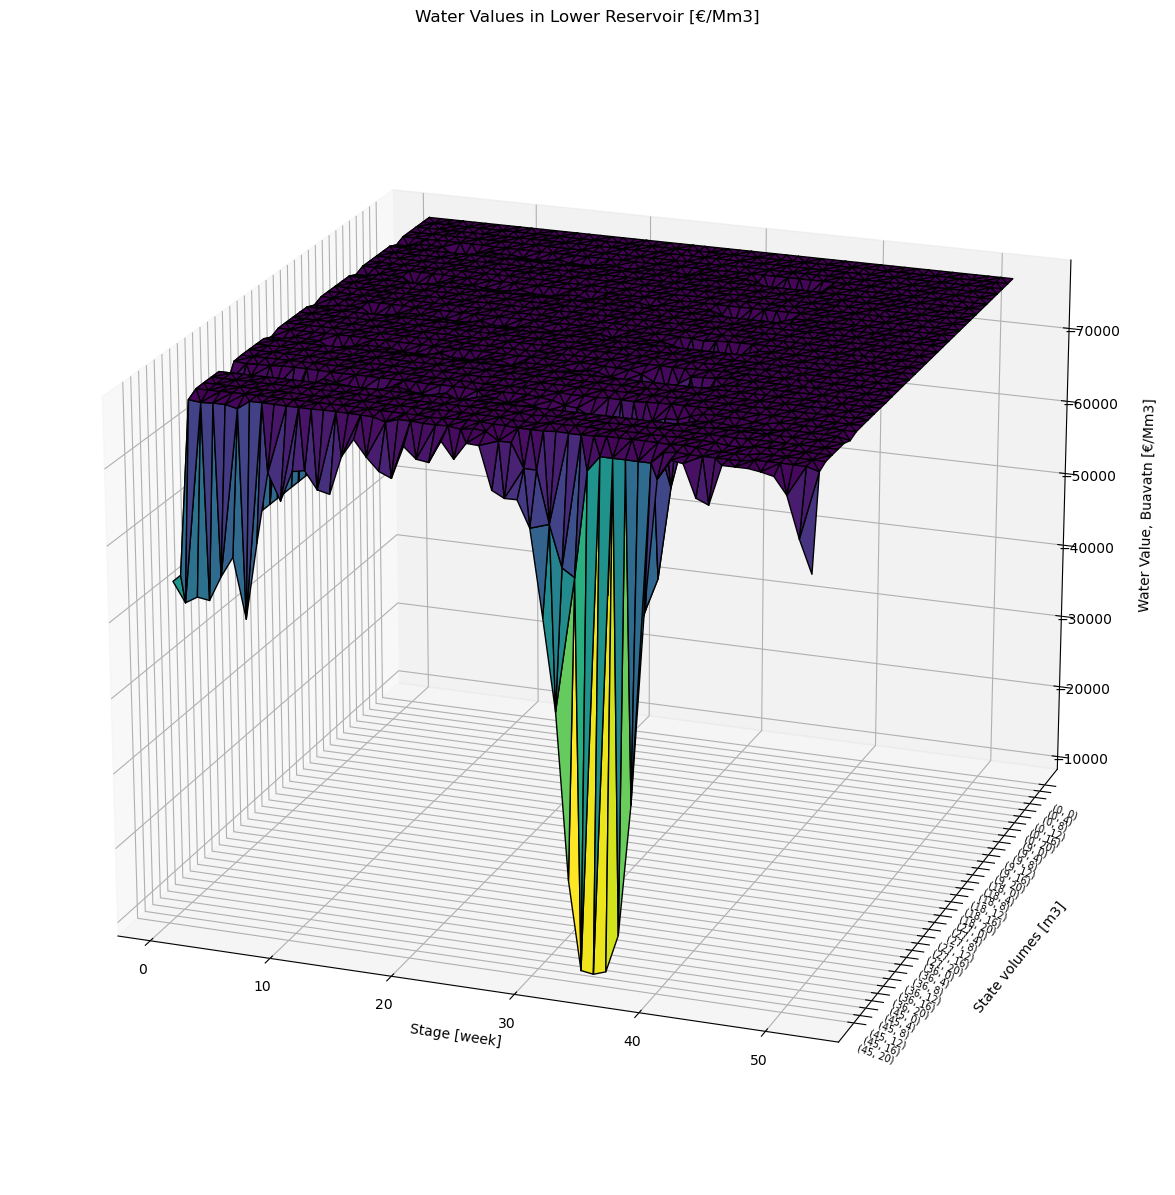

In [ ]:
# Extract the stage, state, and future cost values from the alpha_dict
stages = [stage for stage, state in Dual_values2.keys()]
state_tuples = [str(state) for stage, state in Dual_values2.keys()]
future_costs = list(Dual_values2.values())

# Create a 3D plot
# Map the state tuples to unique numeric values
state_mapping = {state: i for i, state in enumerate(state_tuples)}
state_numeric = [state_mapping[state] for state in state_tuples]

# Create a 3D plot
fig = plt.figure(figsize=(20, 15))
ax = fig.add_subplot(111, projection='3d')

# Create arrays for stages, state_numeric, and future_costs
stages_array = np.array(stages)
state_numeric_array = np.array(state_numeric)
future_costs_array = np.array(future_costs)


# Filter data for stages 0 to 52
filtered_stages = [stage for stage in stages if stage <=52]
filtered_indices = [i for i, stage in enumerate(stages) if stage <= 52]

filtered_state_numeric = np.array(state_numeric)[filtered_indices]
filtered_future_costs = np.array(future_costs)[filtered_indices]

# Plot the 3D surface using plot_trisurf
ax.plot_trisurf(np.array(filtered_stages), filtered_state_numeric, filtered_future_costs, cmap='viridis', edgecolor='k')
ax.view_init(560, -110)
# Set labels for the axes with rotated and fewer tick labels, and adjust position
y_ticks = list(state_mapping.values())
y_labels = list(state_mapping.keys())
# Adjust the number of displayed ticks for better readability
stride = max(1, len(y_labels) // 36)  # Adjust the denominator for desired spacing
ax.set_yticks(y_ticks[::stride])
ax.set_yticklabels(y_labels[::stride], rotation=-20, ha='center', fontsize=7)   # Adjust rotation and ha as needed
ax.set_xlabel('Stage [week]')
ax.set_ylabel('State volumes [m3]', labelpad=20)
ax.set_zlabel('Water Value, Buavatn [€/Mm3]', labelpad=20)

ax.tick_params(axis='y', pad=5)

# Adjust the position and spacing of y-axis ticks
#ax.yaxis.set_ticks_position('left')  # Set the ticks to the left side
#ax.yaxis.set_label_coords(-0.15, 0.5)  # Adjust the position as needed
#ax.yaxis.set_tick_params(pad=20)

plt.title("Water Values in Lower Reservoir [€/Mm3]")

# Add colorbar
#cbar = fig.colorbar(ax.plot_trisurf(stages_array, state_numeric_array, future_costs_array, cmap='viridis', edgecolor='k'), ax=ax, shrink=0.5, aspect=10)
#cbar.set_label('Water Value Reservoir 1 [€/Mm3]')

plt.show()